In [340]:
from skimage import img_as_float
import matplotlib.pyplot as plt
import numpy as np

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 10
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax,cmap="gray")
        ax.set_title(label)

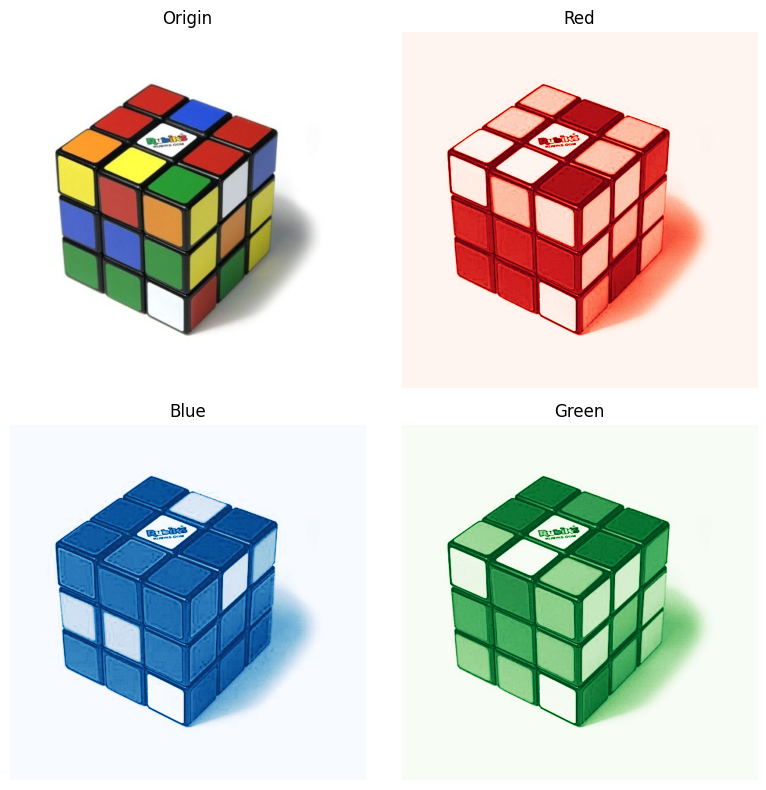

In [341]:
import cv2

import random as rng
from scipy import ndimage as ndi

input_image = cv2.imread('images/square6.jpg')
black_back_image = 255 - input_image

blue, green, red = cv2.split(black_back_image)

# high pass per il colore rosso -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(red, (9,9), 0)
high_pass = cv2.subtract(red, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale rossa
red = cv2.add(red, high_pass)

# high pass per il colore blu -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(blue, (9,9), 0)
high_pass = cv2.subtract(blue, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale blu
blue = cv2.add(blue, high_pass)

# high pass per il colore verde -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(green, (9,9), 0)
high_pass = cv2.subtract(green, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale verde
green = cv2.add(green, high_pass)


plt.figure(figsize=(8, 8))

# Prima immagine
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.title('Origin')
plt.axis('off')

# Seconda immagine
plt.subplot(2, 2, 2)
plt.imshow(red, cmap='Reds')
plt.title('Red')
plt.axis('off')

# Terza immagine
plt.subplot(2, 2, 3)
plt.imshow(blue, cmap='Blues')
plt.title('Blue')
plt.axis('off')

# Quarta immagine
plt.subplot(2, 2, 4)
plt.imshow(green, cmap='Greens')
plt.title('Green')
plt.axis('off')

plt.tight_layout()  # Aggiunge spaziatura tra le immagini per una migliore visualizzazione
plt.show()

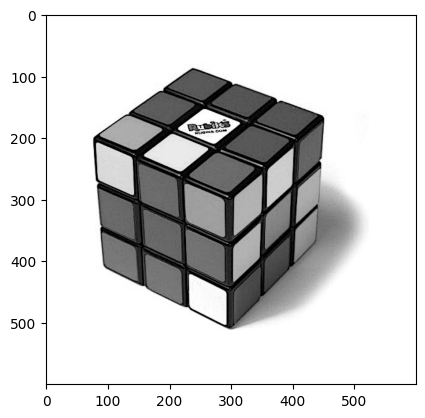

In [342]:
# Unione dei colori
HP_gray_image = 255 - cv2.cvtColor(cv2.merge([blue, green, red],), cv2.COLOR_BGR2GRAY) # immagine High Pass in B/W
plt.imshow(HP_gray_image,cmap="gray")

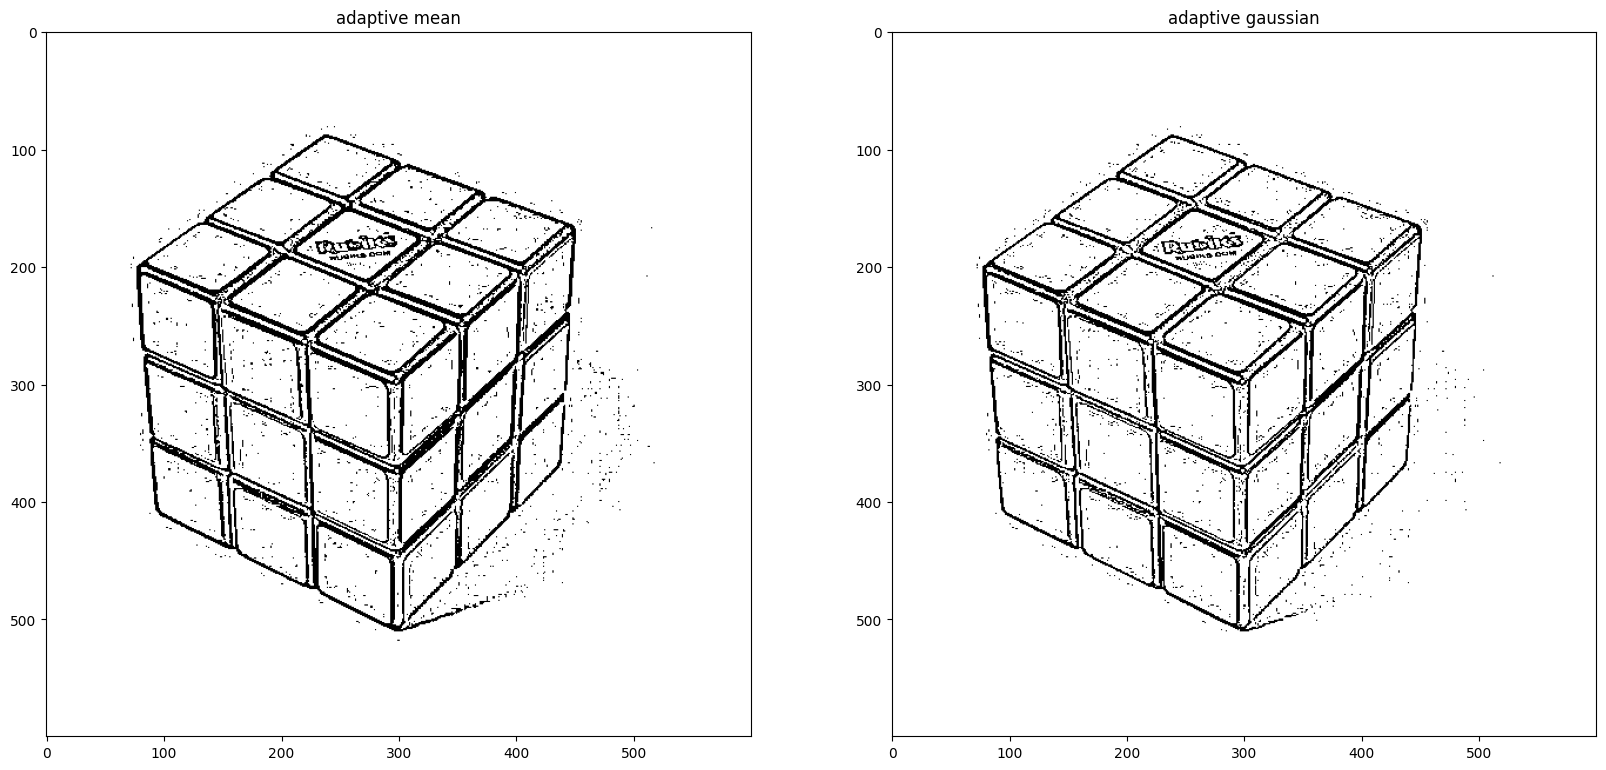

In [343]:
# Applica la soglia adattativa
# cv.ADAPTIVE_THRESH_MEAN_C: The threshold value is the mean of the neighbourhood area minus the constant C. (l'ultimo campo è la C, il penultimo è la grandezza dell'area dove effettuare l'average)
# Al variare della C (ultimo valore) si genera più o meno rumore, a scapito di creare buchi nei lati.
# Al variare della finestra (penultimo valore) cambia la grandezza dei bordi, a scapito di generare rumore

adaptive_mean = cv2.adaptiveThreshold(HP_gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 7)
adaptive_gaussian = cv2.adaptiveThreshold(HP_gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 7) 

# Scelto il metodo con media (non gaussiana) dato che non abbiamo grosse variazioni di luminosità nell'imamgine, l'unica variazione è fra le faccie del lato (se avessimo avuto variazioni fra i singoli cubetti allora la gaussiana avrebbe avuto più senso)

titles=['adaptive mean', 'adaptive gaussian']
imshow_all(adaptive_mean, adaptive_gaussian, titles=titles)

<Figure size 800x800 with 0 Axes>

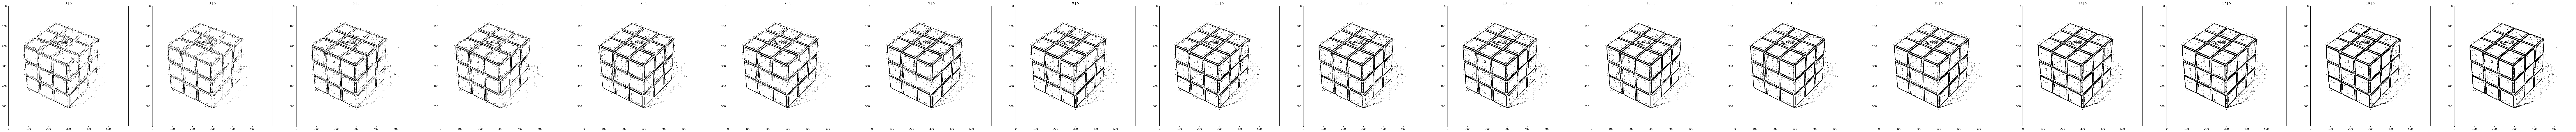

In [344]:
# Verifica di quale combinazione di valori genera la separazione migliore
all_images = []
titles = []
c=5
plt.figure(figsize=(8, 8))
for i in np.arange(1, 10, 0.5):
    all_images.append(cv2.adaptiveThreshold(HP_gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, (2*(int(np.floor(i))))+1, c))
    titles.append(str((2*(int(np.floor(i))))+1)+' | '+str(c))

    total_pixels = HP_gray_image.shape[0] * HP_gray_image.shape[1]
    white_pixel_percentage = (np.sum(all_images.pop == 255) / total_pixels) * 100
    c = max(5, c - 1) if white_pixel_percentage > 0.5 else c

images = [img_as_float(img) for img in all_images]
vmin = min(map(np.min, images))
vmax = max(map(np.max, images))
ncols = len(images)
height = 10
width = height * len(images)
fig, axes = plt.subplots(nrows=1, ncols=ncols,figsize=(width, height))
for ax, img, label in zip(axes.ravel(), images, titles):
    ax.imshow(img, vmin=vmin, vmax=vmax,cmap="gray")
    ax.set_title(label)

In [345]:
# Generazione pixellazione, median filter e gaussiano, sulla lista di generazione precedente
from skimage import filters

pixelated = []
mean_filtered = []
gaussian_filtered = []
mean_kernel = np.full((3, 3), 1/9)
print(mean_kernel)

for i in np.arange(0, 18):
    pixelated.append(all_images[i][::2, ::2])
    mean_filtered.append(ndi.correlate(all_images[i], mean_kernel))
    # conversione formato, obbligatoria sennò il countors detection va in errore
    tmp = filters.gaussian(img_as_float(all_images[i]), sigma=1)
    tmp *= 255/tmp.max() 
    tmp = np.array(tmp, np.uint8)
    gaussian_filtered.append(tmp)


[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


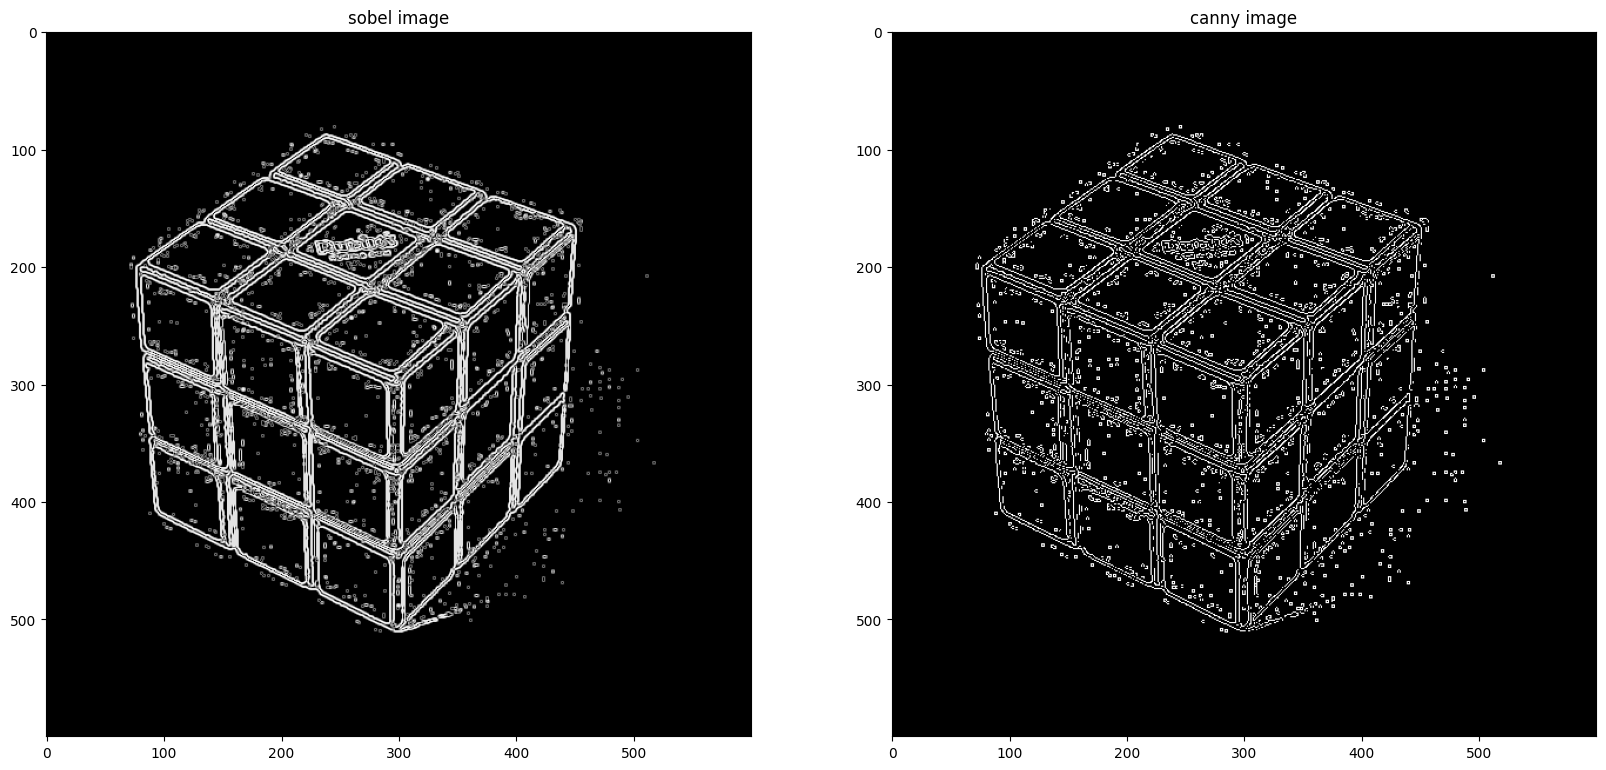

In [346]:
# comparazione fra i edge-detection filters
sobel_image = filters.sobel(cv2.adaptiveThreshold(HP_gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 7) )
# conversione formato, obbligatoria sennò il countors detection va in errore
sobel_image *= 255/sobel_image.max() 
sobel_image = np.array(sobel_image, np.uint8)

canny_image = cv2.Canny(cv2.adaptiveThreshold(HP_gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 7), 30, 200)

titles=['sobel image', 'canny image']
imshow_all(sobel_image, canny_image, titles=titles)
# Si riesce a vedere chiaramente che il sobel riesce ad eliminare maggiormente il rumore

Number of compatible contours found from ORIGINAL (ADAPTIVE_THRESH_MEAN_C) image = 8
Number of compatible contours found from ORIGINAL (ADAPTIVE_THRESH_MEAN_C) image = 8
Number of compatible contours found from ORIGINAL (ADAPTIVE_THRESH_MEAN_C) image = 11
Number of compatible contours found from ORIGINAL (ADAPTIVE_THRESH_MEAN_C) image = 11
Number of compatible contours found from ORIGINAL (ADAPTIVE_THRESH_MEAN_C) image = 13
Number of compatible contours found from ORIGINAL (ADAPTIVE_THRESH_MEAN_C) image = 13
Number of compatible contours found from ORIGINAL (ADAPTIVE_THRESH_MEAN_C) image = 14
Number of compatible contours found from ORIGINAL (ADAPTIVE_THRESH_MEAN_C) image = 14
Number of compatible contours found from ORIGINAL (ADAPTIVE_THRESH_MEAN_C) image = 17
Number of compatible contours found from ORIGINAL (ADAPTIVE_THRESH_MEAN_C) image = 17
Number of compatible contours found from ORIGINAL (ADAPTIVE_THRESH_MEAN_C) image = 18
Number of compatible contours found from ORIGINAL (ADAPT

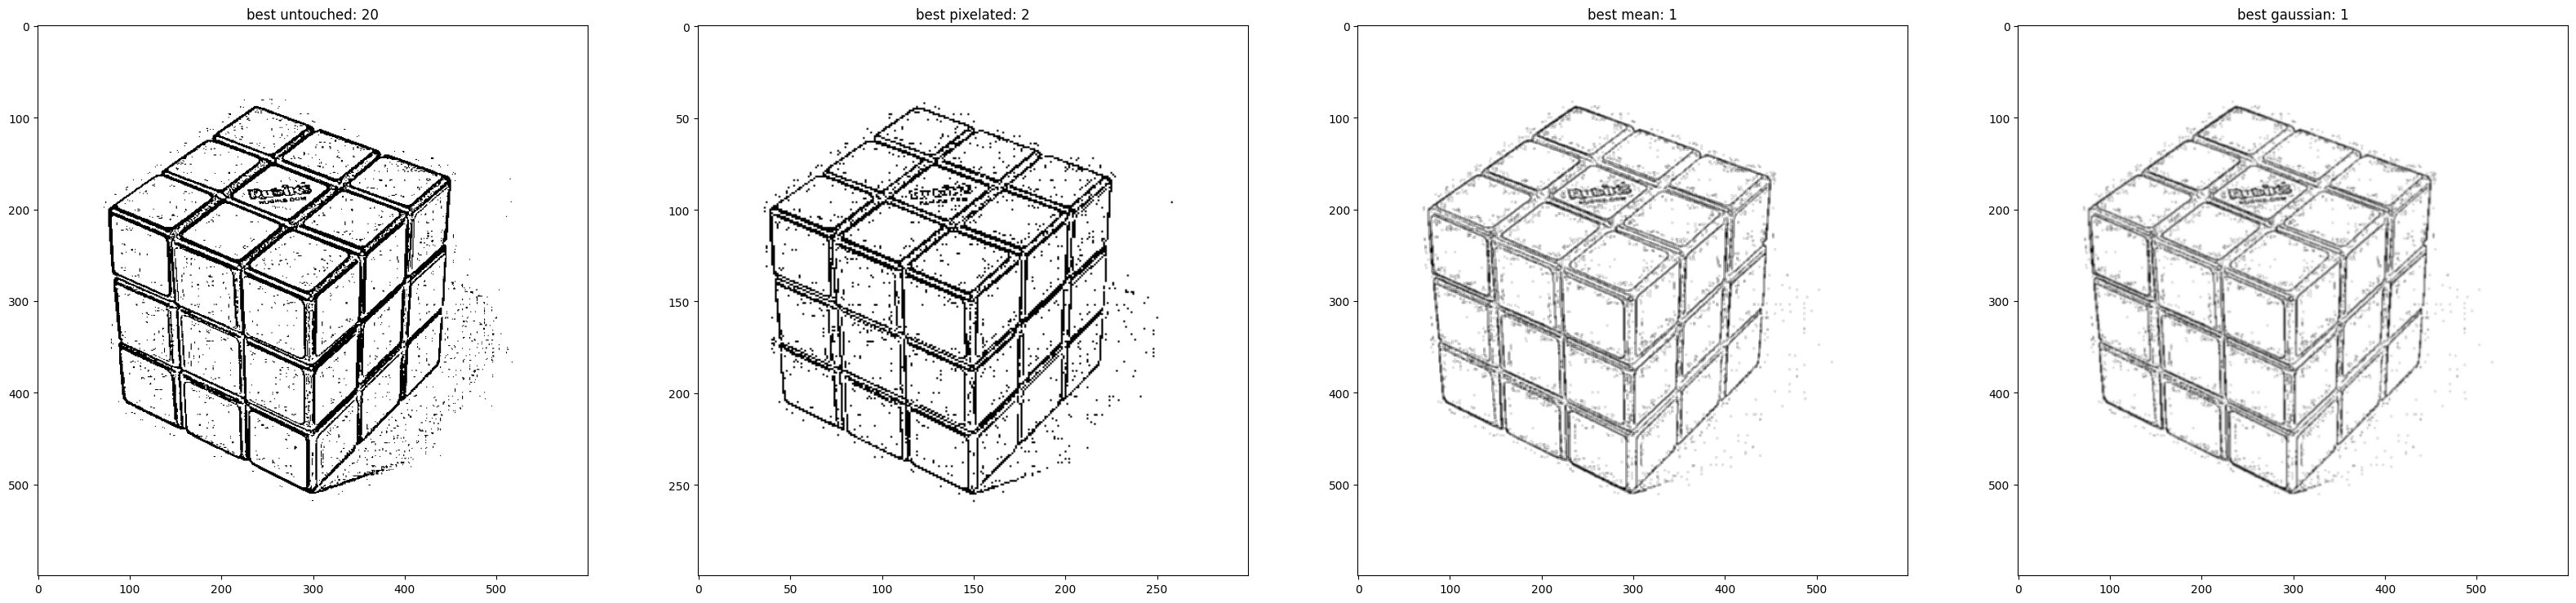

In [347]:
# Verifica finale per vedere quale combinazione funzione meglio
b1=b2=b3=b4=0 # massimi delle singole modalità
i1=i2=i3=i4=input_image # immagini che hanno il massimo per singole modalità

for i in np.arange(0, 18):
    contours, _ = cv2.findContours(all_images[i], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    for j, c in enumerate(contours):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        epsilon = 0.04 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        if len(approx) == 4 and cv2.contourArea(approx) > 1000:
            filtered_contours.append(approx) 
    found = len(filtered_contours)
    print("Number of compatible contours found from ORIGINAL (ADAPTIVE_THRESH_MEAN_C) image = " + str(found)) 
    if(found > b1): 
        b1 = found
        i1 = all_images[i]
        

for i in np.arange(0, 18):
    contours, _ = cv2.findContours(pixelated[i], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    for j, c in enumerate(contours):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        epsilon = 0.04 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        if len(approx) == 4 and cv2.contourArea(approx) > 1000:
            filtered_contours.append(approx) 
    found = len(filtered_contours)
    print("Number of compatible contours found from PIXELATED image = " + str(found)) 
    if(found > b2): 
        b2 = found
        i2 = pixelated[i]

for i in np.arange(0, 18):
    contours, _ = cv2.findContours(mean_filtered[i], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    for j, c in enumerate(contours):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        epsilon = 0.04 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        if len(approx) == 4 and cv2.contourArea(approx) > 1000:
            filtered_contours.append(approx) 
    found = len(filtered_contours)
    print("Number of compatible contours found from MEAN FILTERED image = " + str(found)) 
    if(found > b3): 
        b3 = found
        i3 = mean_filtered[i]

for i in np.arange(0, 18):
    contours, _ = cv2.findContours(gaussian_filtered[i], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    for j, c in enumerate(contours):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        epsilon = 0.04 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        if len(approx) == 4 and cv2.contourArea(approx) > 1000:
            filtered_contours.append(approx) 
    found = len(filtered_contours)
    print("Number of compatible contours found from GAUSSIAN FILTERED image = " + str(found)) 
    if(found > b4): 
        b4 = found
        i4 = gaussian_filtered[i]

titles=['best untouched: '+str(b1), 'best pixelated: '+str(b2), 'best mean: '+str(b3), 'best gaussian: '+str(b4)]
imshow_all(i1, i2, i3, i4, titles=titles)

Number of Contours found = 3449


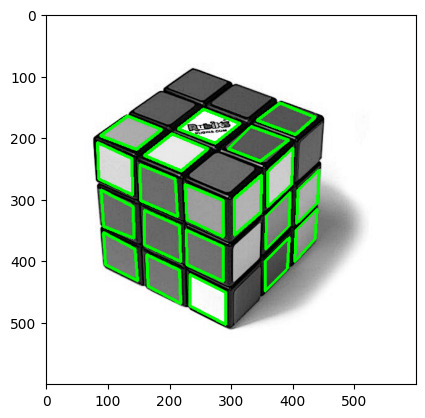

In [348]:
contours, _ = cv2.findContours(sobel_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

print("Number of Contours found = " + str(len(contours))) 

# filtra i contorni in al numero di angoli di un poligono + area
filtered_contours = []
for i, c in enumerate(contours):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))

    # approssimazione ad un poligono
    epsilon = 0.07 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, epsilon, True)
    
    # filtraggio
    if len(approx) == 4 and 5000 > cv2.contourArea(approx) > 1000:
        filtered_contours.append(approx) 



# visualizza l'immagine risultante
tmp = cv2.cvtColor(HP_gray_image,cv2.COLOR_GRAY2RGB)
cv2.drawContours(tmp, filtered_contours, -1, (0, 255, 0), thickness = 3)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

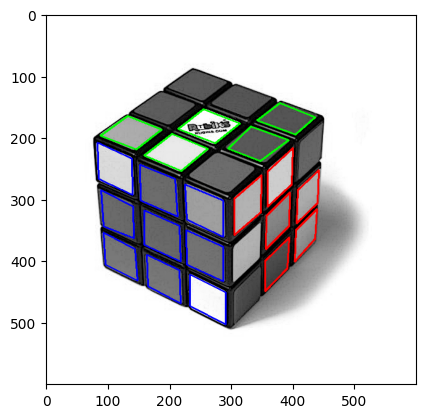

In [349]:
image_height, image_width, _ = image.shape
center_x = image_width // 2
center_y = image_height // 2

# duddivide i quadrati in base alla loro posizione rispetto al centro
top_quadrati = []
right_quadrati = []
left_quadrati = []
for contour in filtered_contours:

    # punto centrale di un quadratino
    M = cv2.moments(contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    # classificazione in base al centro del rubiks cube
    if cY < center_y - abs(center_x-cX)/2:
        top_quadrati.append(contour)
    elif cX > center_x:
        right_quadrati.append(contour)
    elif cX < center_x:
        left_quadrati.append(contour)

# output
tmp = cv2.cvtColor(HP_gray_image,cv2.COLOR_GRAY2RGB)
cv2.drawContours(tmp, top_quadrati, -1, (0, 255, 0), 2)
cv2.drawContours(tmp, right_quadrati, -1, (0, 0, 255), 2)
cv2.drawContours(tmp, left_quadrati, -1, (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

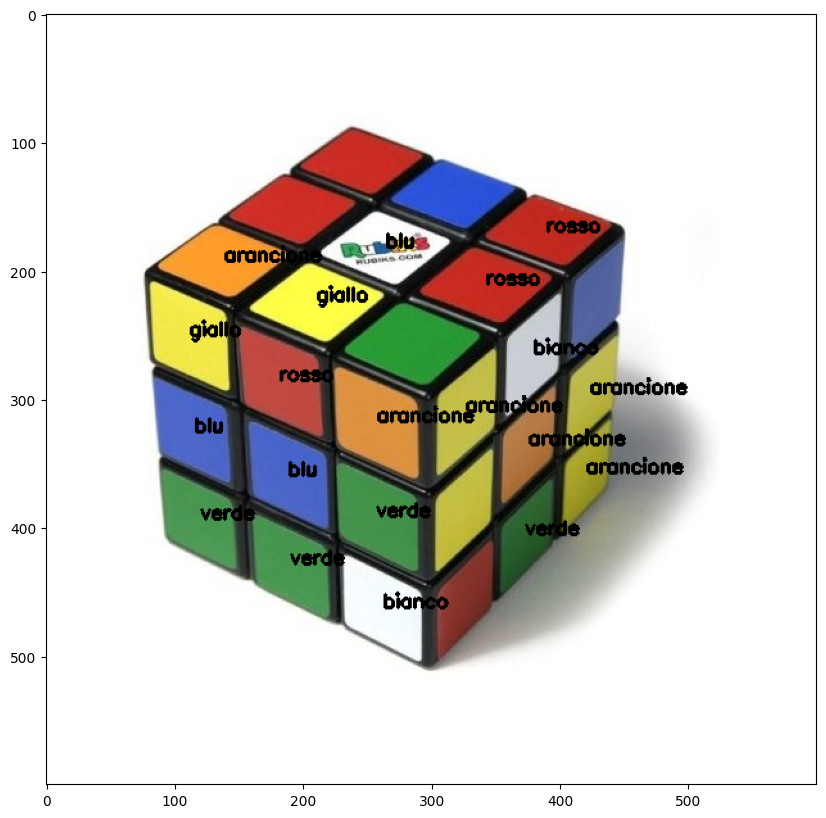

In [350]:
color_palette = {
    'rosso': (0, 0, 255),
    'verde': (0, 255, 0),
    'blu': (255, 0, 0),
    'bianco': (255, 255, 255),
    'giallo': (0, 255, 255),
    'arancione': (0, 165, 255)
}

for contour in filtered_contours:
    # trova il punto centrale del contour
    M = cv2.moments(contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    # lettura colore al punto centrale
    image = 255 - image
    color_at_center = input_image[cY, cX]

    # sampling del colore più vicino nella palette
    closest_color = min(color_palette.keys(), key=lambda x: np.linalg.norm(np.array(color_palette[x]) - color_at_center))

    # inserimento nome colore
    cv2.putText(input_image, closest_color, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

# output
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))

Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: True
Uno dei lati è verticale: False
Uno dei lati è verticale: False
Uno dei lati è verticale: False
Uno dei lati è verticale: False
Uno dei lati è verticale: False


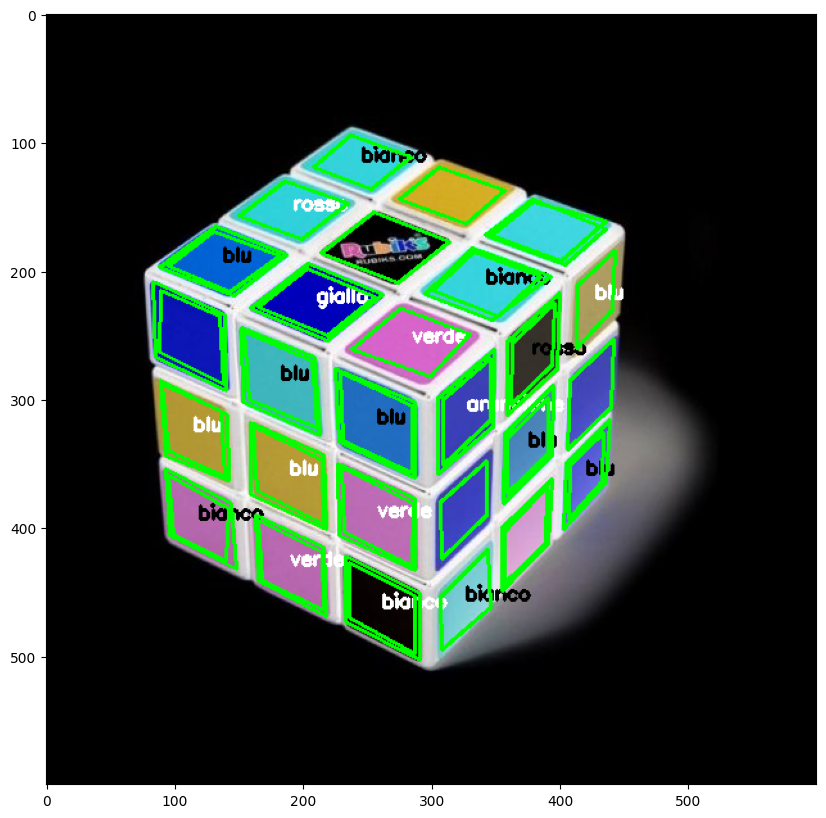

In [351]:
# completamento del cubo di rubik se non identificati tutti i quadrati

for contour in filtered_contours:
    vertices = contour.reshape(-1, 2)

    # vettore tra il primo e l'ultimo vertice
    vector1 = vertices[0] - vertices[1]
    vector2 = vertices[1] - vertices[2]
    vector3 = vertices[2] - vertices[3]
    vector4 = vertices[3] - vertices[0]

    # angolo tra il vettore e un vettore verticale (0, 1)
    angle1 = np.degrees(np.arctan2(vector1[1], vector1[0]))
    angle2 = np.degrees(np.arctan2(vector2[1], vector2[0]))
    angle3 = np.degrees(np.arctan2(vector3[1], vector3[0]))
    angle4 = np.degrees(np.arctan2(vector4[1], vector4[0]))

    # verifica se l'angolo è vicino a 90 gradi (verticale)
    is_vertical = np.isclose(angle1, 90.0, atol=10.0) or np.isclose(angle2, 90.0, atol=10.0) or np.isclose(angle3, 90.0, atol=10.0) or np.isclose(angle4, 90.0, atol=10.0)

    print(f"Uno dei lati è verticale: {is_vertical}")

    # disegna il quadrato sull'immagine originale
    cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)

# visualizza l'immagine risultante
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

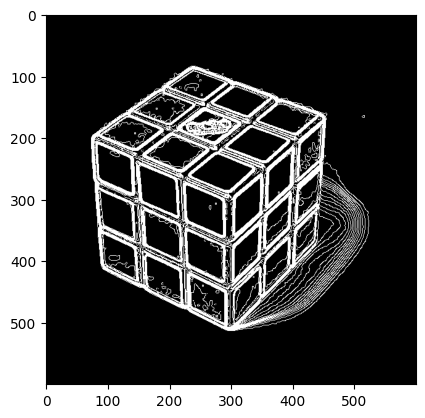

In [352]:
# NON TOCCARE

blur = cv2.GaussianBlur(HP_gray_image, (7, 7), 0)
ret,threshold_image = cv2.threshold(blur,10,255,cv2.THRESH_BINARY)
edged = cv2.Canny(threshold_image, 30, 200)

plt.imshow(edged)
for i in range(24):
    ret,threshold_image = cv2.threshold(blur,10*(i+2),255,cv2.THRESH_BINARY)
    edge = cv2.Canny(threshold_image, 30, 200)
    edged = cv2.add(edged,edge)

plt.imshow(edged, cmap="gray")